In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.linalg import solve_triangular
from sys import stdout
import math


In [3]:
from Experiment import *
from Parameters import *
from Fault import *
from Algorithm import *
from Utils import *

In [4]:
from gmres import *
import gmres_display

### Define algorithm parameters

In [5]:
# parameters that won't change during the whole experiment
epsilon = 1.e-10

algorithm_parameters = Parameters()
algorithm_parameters["restart"] = None
algorithm_parameters["tol"] = epsilon
algorithm_parameters["save_data"] = {"iteration_count",
                                     "residual",
                                     "residuals",
                                     "true_residual",
                                     "true_residuals",
                                     #"orthogonality",
                                     #"arnoldi",
                                     "faults",
                                     "H",
                                     "V",
                                     "givens",
                                     "y",
                                     "checksum",
                                     #"threshold",
                                     #"criteria",
                                     #"delta",
                                     #"true_delta"
                                    }



### define faulty matvec operator

In [6]:
def faulty_product(A, Faulty = None):
    if Faulty:
        return lambda v: Faulty.product(A, v)
    else:
        return lambda v: A.dot(v)

### Define implementation and callback

In [7]:
def implementation(self, input, algorithm_parameters, experiment_parameters):
    A = input["A"]
    b = input["b"]
    x0= input["x0"]
    
    parameters = algorithm_parameters.copy()
    parameters.update(experiment_parameters)
    
    n = A.shape[0]
    normb = np.linalg.norm(b)
    maxiter = parameters.get("maxiter", n)
    tol = parameters.get("tol", 1.e-10)
    restart = parameters.get("restart", None)
    m = restart if restart else maxiter
    save_data = parameters.get("save_data", {})
    A1T = A.sum(axis=0)
    
    if "residuals" in save_data:
        self.data["residuals"] = [1.]
    if "true_residuals" in save_data:    
        self.data["true_residuals"] = [1.]
    if "measured_checksum" in save_data:
        self.data["measured_checksum"] = [0.]
    if "true_checksum" in save_data:
        self.data["true_checksum"] = [0.]
    if "checksum" in save_data:
        self.data["checksum"] = [0.]
    if "true_delta" in save_data:
        self.data["true_delta"] = [0.]
    if "delta" in save_data:
        self.data["delta"] = [0.]
    if "y" in save_data:
        self.data["y"] = np.zeros((maxiter, maxiter))
    
    if parameters.get("vulnerable", True):
        faulty = Fault(parameters.get("fault_parameters", Parameters()))
    else:
        faulty = None
    A_ = LinearOperator((n, n), 
                        matvec=faulty_product(A, faulty),
                        dtype=A.dtype)

    def callback(iter_num, resid, work, work2, ijob):
        R = work[0*n:1*n]
        S = work[1*n:2*n]
        W = work[2*n:3*n]
        Y = work[3*n:4*n]
        AV= work[4*n:5*n]
        V = work[5*n:(5+iter_num)*n]
        v = work[(5+iter_num) * n:(6 + iter_num)*n]
        H = work2[:iter_num*(m+1)]
        c = work2[m*(m+1):m*(m+2)]
        s = work2[m*(m+2):m*(m+3)]
        
        if (ijob == 3):
            if ("measured_checksum" in save_data or 
                "checksum" in save_data):
                measured_checksum = np.sum(AV)
            if ("true_checksum" in save_data or 
                "checksum" in save_data):
                true_checksum = np.dot(A1T, v)
            if "measured_checksum" in save_data:
                self.data["measured_checksum"] += [measured_checksum]
            if "true_checksum" in save_data:
                self.data["true_checksum"] += [true_checksum]
            if "checksum" in save_data:
                self.data["checksum"] += [abs(measured_checksum - 
                                                   true_checksum)[0, 0]]



        if ("H" in save_data or 
            "V" in save_data or
            "y" in save_data or 
            "delta" in save_data or
            "true_delta" in save_data or
            "true_residual" in save_data or
            "true_residuals" in save_data):
            H = H.reshape((iter_num, m+1))[:,:iter_num]
            V = V.reshape((iter_num, n))
            S = S[:iter_num]
            if ("y" in save_data or 
                "true_residuals" in save_data or 
                "true_delta" in save_data or 
                "delta" in save_data):
                try:
                    y = solve_triangular(H.T, S)
                except:
                    y = np.zeros(S.shape)
                true_resid = np.linalg.norm(A.dot(x0+np.dot(V.T, y)) - b) / normb
        
        if "y" in save_data:
            self.data["y"][:y.shape[0], iter_num-1] = y
        if "iteration_count" in save_data:
            self.data["iteration_count"] = iter_num 
        if "residual" in save_data:
            self.data["residual"] = resid
        if "residuals" in save_data:
            self.data["residuals"] += [resid]
        if "true_residual" in save_data:
            self.data["true_residual"] = true_resid
        if "true_residuals" in save_data:
            self.data["true_residuals"] += [true_resid]
        if "delta" in save_data:
            self.data["delta"] += [abs(resid - true_resid)] #TODO
        if "true_delta" in save_data:
            self.data["true_delta"] += [abs(resid - true_resid)] 

              
        if "H" in save_data:
            self.data["H"] = H.T
        if "V" in save_data:
            self.data["V"] = V.T
        if "givens" in save_data:
            self.data["givens_c"] = c[:iter_num]
            self.data["givens_s"] = s[:iter_num]

        if faulty and "faults" in save_data:
            self.data["faults"] = faulty.faults
            
    x = gmres(A_, 
              b, 
              x0, 
              tol = tol,
              maxiter = maxiter,
              restart = restart,
              callback = callback if parameters.get("save_data", None) else None
             )
    return x

In [8]:
gmres_algorithm = Algorithm(algorithm_parameters, implementation)

### Define gmres inputs (linear system to be solved)

In [9]:
input = load_mat("mat_files/sherman2.mat", sparse = True)
A = input["A"]
b = input["b"]
x0 = input["x0"]
inputs = [input]
n = A.shape[0]
problem = input["problem"]
print n

1080


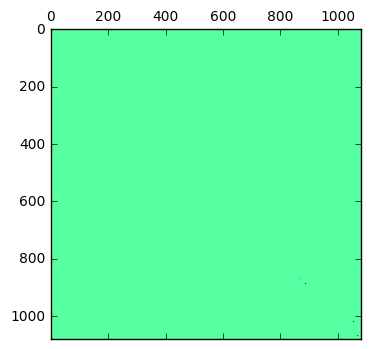

In [10]:
try:
    plt.matshow(A)
except:
    plt.matshow(A.toarray())

## Run GMRES

In [11]:
# Parameters that may change during the experiment
# Experiment parameters override Algorithm parameters
experiment_parameters = Parameters()

experiment_parameters["vulnerable"] = False
experiment_parameters["tol"] = epsilon
experiment_parameters["full"] = False

In [12]:
F = Experiment(experiment_parameters, gmres_algorithm)
F.set_inputs(inputs)

In [13]:
F.run(show_progress=True, n=1)

Complete ! 


In [14]:
import os
import sys
#import mysql.connector as mariadb
import pymysql as mariadb
mariadb_connection = mariadb.connect(user='resilience', 
                                     #password='resilience_password', 
                                     passwd='resilience_password',
                                     #host='192.168.1.48',
                                     database='gmres')
cursor = mariadb_connection.cursor()


In [15]:

def save_linearsystem(input):
    try:
        cursor.execute("""SELECT name FROM LinearSystem WHERE name = %s """, (str(input["name"]),))
        rows = cursor.fetchone()
        if (not rows):
            cursor.execute("""INSERT INTO LinearSystem (file, name) VALUES (%s,%s)""",(input["file"], str(input["name"])))
            mariadb_connection.commit()
            return
    except:
        print sys.exc_info()[0]
    mariadb_connection.rollback()
        
def save_experiment(input, output, parameter, data):
    try:
        request = "INSERT INTO Experiment (A, x, tol, m"
        values = [str(input["name"]), output.tostring(), float(parameter["tol"]), int(parameter["m"])]
        v = "%s, %s, %s, %s"

        for key in sorted(data.iterkeys()):
            if key == "faults" and len(data["faults"]) == 0:
                continue
                
            request += ", "
            v += ", "
            
            if key == "faults" and len(data["faults"]) > 0:
                request += "fault_i, "
                values += [int(data["faults"][0]["loc"]["i"])]
                v += "%s, "
                request += "fault_k, "
                values += [int(data["faults"][0]["loc"]["k"])]
                v += "%s, "
                request += "fault_f, "
                values += [int(data["faults"][0]["timer"])]
                v += "%s, "
                request += "fault_bit, "
                values += [int(data["faults"][0]["bit"])]
                v += "%s, "
                request += "fault_reg"
                values += [int(data["faults"][0]["register"])]
                v += "%s" 
            elif key == "iteration_count":
                request += "l"
                values += [int(data["iteration_count"])]
                v += "%s"

            else:
                if key != "faults":
                    request += key
                    v += "%s"
                    if key == "H" or key == "V" or key == "y" or key == "givens_c" or key == "givens_s":
                        values += [data[key].tostring()]
                    elif key == "residuals" or key == "true_residuals" or key == "checksum":
                        values += [np.asarray(data[key]).tostring()]
                    elif key == "residual" or key == "true_residual":
                        values += [float(data[key])]
                    elif key == "iteration_count":
                        values += [int(data[key])]
                    else:
                        values += [data[key]]
        

        request += ") VALUES (" + v + ")"
        cursor.execute(request, tuple(values))

        mariadb_connection.commit()

    except:
        mariadb_connection.rollback()
    
def save_database_callback(input, output, parameter, data):
    save_linearsystem(input)
    save_experiment(input, output, parameter, data)

In [ ]:
import random

def experiment_parameters_generator_random(A, vulnerable = True,
                                    tol = 0,
                                    m = 0, 
                                    fault_callback = lambda fault: (stdout.write(" %s " % str(fault))),
                                    max_iter = 0
                                   ):

    
    parameters = Parameters()
    parameters["vulnerable"] = vulnerable
    parameters["tol"] = tol
    parameters["m"] = max_iter #TODO
    fault_parameters = {}
    fault_parameters["fault_callback"] = fault_callback
    fault_parameters["vulnerable"] = vulnerable
            
    parameters["fault_parameters"] = fault_parameters
        
    while (True):
        non_zero = A.nonzero()
        index = int(np.random.rand()*len(non_zero[0]))
        fault_parameters["fault_indices"] = {"i": non_zero[0][index], 
                                             "j":0, 
                                             "k": non_zero[1][index]}

        fault_parameters["timer"] = random.choice([i for i in xrange(m)])
        fault_parameters["bit"] = 1#random.choice([i for i in xrange(64)])
        yield parameters

In [ ]:

F_parameters = Parameters()
F_parameters["restart"] = None
F_parameters["tol"] = epsilon
F_parameters["vulnerable"] = False


for mat_file in os.listdir(os.getcwd()+os.sep+"mat_files", ):
    try:
        if mat_file.endswith(".mat"): 
            print mat_file
            _inputs = [load_mat(os.getcwd()+os.sep+"mat_files"+os.sep+mat_file, sparse = True)]
            F_parameters["m"] = _inputs[0]["A"].shape[0]
            _F = Experiment(F_parameters, gmres_algorithm, callback=save_database_callback, save_data=True)
            _F.set_inputs(_inputs)
            _F.run(n = 1)
            if has_converged(_F.get_data()[0], epsilon = epsilon):
                _min_iteration = when_has_converged(_F.get_data()[0], epsilon = epsilon)
                if _min_iteration and _min_iteration > 5:
                    _G = Experiment(experiment_parameters_generator_random(A = _inputs[0]["A"], m=_min_iteration-1, tol = epsilon / 100, max_iter=_inputs[0]["A"].shape[0]), 
                                    gmres_algorithm, 
                                    callback=save_database_callback,
                                    save_data = False)
                    _G.set_inputs(_inputs)
                    _G.run(show_progress=True, n=1000)
                    #_data = filter(lambda d: len(d["faults"]) > 0 and not d["breakdown"], _G.get_data())
    except RuntimeError:
        print "Problème avec ", mat_file

rajat12.mat
9 %  {'register_before': 0.085473090228741305, 'loc': {'i': 1135, 'k': 1139, 'j': 0}, 'value_before': 0.034677530398891147, 'register': 2, 'timer': 312, 'register_after': 0.08547499757737412, 'bit': 26, 'value_after': 0.034677528628871614}  {'register_before': -3.4180201999785322e-05, 'loc': {'i': 700, 'k': 0, 'j': 0}, 'value_before': 0.0003920021378196375, 'register': 3, 'timer': 229, 'register_after': -3.418020199978535e-05, 'bit': 61, 'value_after': 0.00039200213781963745}  {'register_before': -0.068599999999999994, 'loc': {'i': 984, 'k': 0, 'j': 0}, 'value_before': -0.00028879946519791422, 'register': 1, 'timer': 66, 'register_after': -3.71881345162528e-21, 'bit': 5, 'value_after': -0.00037223383740780025}  {'register_before': -0.093599220570611374, 'loc': {'i': 1355, 'k': 1355, 'j': 0}, 'value_before': -0.021724316740278186, 'register': 2, 'timer': 201, 'register_after': -0.09360684996514262, 'bit': 24, 'value_after': -0.021726131765607774}  {'register_before': 0.00125

In [ ]:
mariadb_connection.close()